# Jobs.ch web scraping

In order to look for a job we usually search current opportunities through job portals such as jobs.ch in order to find jobs that are relevant to our profile. The goal of this notebook is to scout potential jobs for the following keywords: "Data Scientist", "Data Analyst", "Data Engineer" and "Data Python".

Here are the steps of web scraping for our task:

- Check robot.txt
- Use 'requests' library to get url content
- Use BeautifulSoup to parse
- Define information/data required
- Use find() to navigate through the parsed html and use get() to extract the information required
- Export extracted data into a pandas dataframe and csv file

## 1. Packages to install

In [1]:
# html parsing
from bs4 import BeautifulSoup

# manipulate dates and times
from datetime import datetime

# os system function to run command in python script
import os

# pandas data analysis toolkit
import pandas as pd

# numpy library for arrays
import numpy as np

# import requests package
import requests

# function to pause the program and space out requests
from time import sleep

# display progress bar
from tqdm import tqdm

## 2. Check robot.txt

https://www.jobs.ch/robots.txt shows the scraping guidelines for the website.

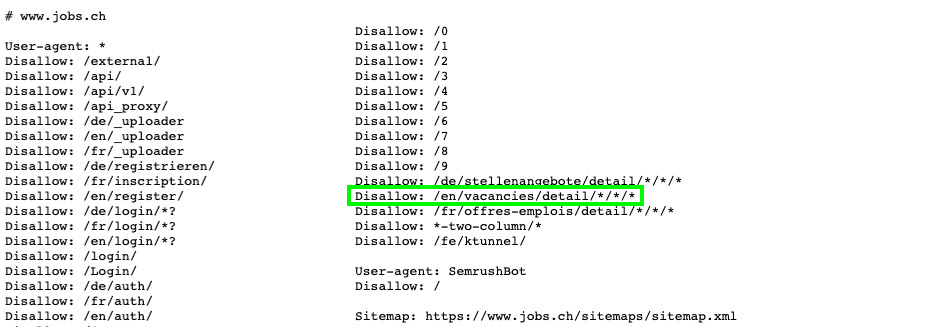

- `*` equals to `any`, meaning that the rules apply to any web scraping script
- The disallow within the green box states that it is not allowed scrape any url with the form `https://www.jobs.ch/en/vacancies/detail/anything/anything/anything`

## 3. Find suitable URL pattern

The best procedure to find the URL pattern is to navigate the website and check how the URL changes. After landing on different pages within the website, we notice that the URL looks pretty much always like the one below with page= with a different number depending on the page, region= with a different number depending on the region, and the term= which is basically our term search with %20 for spaces.

Final URL pattern for search page with results:
- https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}

URL pattern to acces to specific job ad details:

- https://www.jobs.ch/en/vacancies/?page={page}&region={reg}&term={key%20word}&jobid={jobid}

The first task will be to parse the serach pages to the the list of URLs of all individual jobs descriptions and subsequently parse each job description for more content.

## 4. Define job titles to search

In [2]:
# create a list of keywords to search
keywords = [
    "Data%20Scientist",
    "Data%20Analyst",
    "Data%20Engineer",
    "Data%20Python"
]

# create empty dictionary
keys_dict = dict()

# replace %20 by space
for key in keywords:
    keys_dict[key] = key.replace("%20", " ")

# output
keys_dict

{'Data%20Scientist': 'Data Scientist',
 'Data%20Analyst': 'Data Analyst',
 'Data%20Engineer': 'Data Engineer',
 'Data%20Python': 'Data Python'}

## 5. Scrape search page for URLs of individual jobs

In the `web_scraping_beautifulsoup` notebook the URL link used was the following https://www.jobs.ch/en/vacancies/detail/{job_id}/?source=vacancy_search, which is present in the robot.txt file as `Disallow`. To bypass this rule the {jobid} will be extracted from the URL retreived in the job ad box and inserted in the URL find in section 3. Ultimately, the get request will be sent to the URL found above and the response will be stored in a file to be used later on. For what concerns going through all pages the following `span` element can be used (attribute `data-cy` value `page-count`).

In [3]:
# get maximum number of pages per keywords
max_pages = []

# get all job ids and description for every keywords search in keywords
for key in keywords:
    page = requests.get(f"https://www.jobs.ch/en/vacancies/?term={key}", timeout=15)
    soup = BeautifulSoup(page.content, "html.parser")
    max_pages.append(
        int(soup.find("span", {"data-cy": "page-count"}).get_text().split("/")[1].strip())
    )
    
max_pages

[28, 30, 83, 38]

In [4]:
# create all URL links for each keyword
links = dict()

for i in range(len(keywords)):
    # current key = key in list
    key = keywords[i]
    
    # emtpy list of links divided per key
    links[key] = []
    
    # URL reconstruction
    link_part_one = "https://www.jobs.ch/"
    link_part_two = "en/vacancies/?page="
    link_part_three = "&term="
    
    # search term
    search_term = key
    
    # get all page links for each key
    for page_number in range(1, max_pages[i]+1):
        
        # URL reconstruction
        url = (
            link_part_one
            + link_part_two
            + str(page_number)
            + link_part_three
            + search_term
        )
        
        # append URLs in links list for each separate key
        links[key].append(url)
        
# output links creation
links

{'Data%20Scientist': ['https://www.jobs.ch/en/vacancies/?page=1&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=2&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=3&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=4&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=5&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=6&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=7&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=8&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=9&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=10&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=11&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=12&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=13&term=Data%20Scientist',
  'https://www.jobs.ch/en/vacancies/?page=14&term=Data%20Scientist',
  'https://www.jobs.ch/

## 6. Extract job ad information

To avoid for the code to stop running whenever a piece of information is missing for any specific job ad try/except will be used in the code structure.

In [5]:
# emtpy dataframe dictionary
dataframes = dict()

for e, (key, link) in enumerate(links.items()):
    # print key in links dictionary
    print(keys_dict[key])
    
    # dataframe setup
    df = pd.DataFrame(columns=["title", "company", "location", "link", "date"])
    
    # for every link
    for e, li in enumerate(link):
        # print links for every key
        print("link:", li)
        # get request with 5 seconds timeout
        page = requests.get(li, timeout=5)
        
        # convert page content into BeautifulSoup object
        soup = BeautifulSoup(page.content, "html.parser")
        
        # get html element for job ads
        job_ads = soup.findAll('article', {'class': 'VacancySerpItemUpdated__ShadowBox-sc-i0986f-0'})
        
        # for all job_ads
        for i in range(len(job_ads)):
            
            # url
            try:
                url = 'https://www.jobs.ch' + job_ads[i].find('a',{'data-cy' : 'job-link'}).get('href')
            except AttributeError:
                url = np.nan
            
            # job title
            try:
                title = job_ads[i].find('a', {'data-cy': 'job-link'}).get('title')
            except AttributeError:
                title = np.nan
            
            # job company
            try:
                company = job_ads[i].find('p', {'class': ["P-sc-hyu5hk-0", "Text__p2-sc-1lu7urs-9"]}).find_next('p').find_next('p').find_next('p').find_next('p').get_text()
            except AttributeError: 
                company = np.nan
            
            # job location
            try:
                location = job_ads[i].find('p', {'class': ["P-sc-hyu5hk-0", "Text__p2-sc-1lu7urs-9"]}).find_next('p').get_text()
            except AttributeError: 
                location = np.nan
            
            # job date posted
            try:
                date = job_ads[i].find("span", attrs={"aria-hidden": "true", "class": "Span-sc-1ybanni-0"}).get("title")
            except AttributeError: 
                date = np.nan

            job_dict = { 
              'title': title, 
              'company': company, 
              'location': location, 
              'date': date,
              'link': url}

            #df = df.append(job_dict, ignore_index=True) -> append is now deprecated, using concat instead
            df = pd.concat([df, pd.DataFrame([job_dict])],ignore_index=True)
    
    dataframes[key] = df

Data Scientist
link: https://www.jobs.ch/en/vacancies/?page=1&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=2&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=3&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=4&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=5&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=6&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=7&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=8&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=9&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=10&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=11&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=12&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=13&term=Data%20Scientist
link: https://www.jobs.ch/en/vacancies/?page=14&term=Data%20Scientist
link: https://

In [6]:
# display separate dataframes for each job search key
for key, value in dataframes.items():
    print(keys_dict[key].upper(), ":")
    display(value)

DATA SCIENTIST :


,title,company,location,link,date
0,GTP - Trading Data Scientist,Vontobel,Zürich,https://www.jobs.ch/en/vacancies/detail/97a081...,21 Februar 2023
1,NLP Machine Learning Data Scientist (w/m/d),die Mobiliar,Bern,https://www.jobs.ch/en/vacancies/detail/1b953d...,09 März 2023
2,Datenspezialist:in / Data Scientist 80-100% (m...,Wüest Partner,Zürich,https://www.jobs.ch/en/vacancies/detail/955a9c...,03 März 2023
3,Data Analyst SME f/m/d,JobCloud AG,Genève / Zürich,https://www.jobs.ch/en/vacancies/detail/750e2a...,13 März 2023
4,Senior Data Analyst (a),Bedag Informatik AG,"Bern, Gutenbergstrasse",https://www.jobs.ch/en/vacancies/detail/dffed1...,22 März 2023
...,...,...,...,...,...
549,DevOps and Quality Assurance,Optravis LLC,Basel,https://www.jobs.ch/en/vacancies/detail/8e0ed7...,15 Februar 2023
550,Développeur en Business intelligence / Datawar...,Published: 15 März 202315 März,Pully,https://www.jobs.ch/en/vacancies/detail/80986b...,21 März 2023
551,BASEL OFFICE - Operations & Development Analys...,Published: 20 Dezember 202220 Dez.,Basel,https://www.jobs.ch/en/vacancies/detail/0aee10...,15 März 2023
552,Analyst - Operations Department,EF Education AG,8001 Zurich,https://www.jobs.ch/en/vacancies/detail/da6cda...,20 Dezember 2022


DATA ANALYST :


,title,company,location,link,date
0,Data Analyst 100% 03.04.2023 bis 30.11.2023,Job Solution AG,Stadt Zürich / Zürichsee / Region Mittelland,https://www.jobs.ch/en/vacancies/detail/04ab24...,23 March 2023
1,Senior Data Analyst (a),Bedag Informatik AG,"Bern, Gutenbergstrasse",https://www.jobs.ch/en/vacancies/detail/dffed1...,22 March 2023
2,Data Analyst SME f/m/d,JobCloud AG,Genève / Zürich,https://www.jobs.ch/en/vacancies/detail/750e2a...,13 March 2023
3,"Junior Data Analyst, 80% - 100% (m/w/d)",DeinDeal AG,Zürich,https://www.jobs.ch/en/vacancies/detail/b4c268...,15 March 2023
4,Data Analyst Leistungen (w/m) Luzern,CSS Versicherung,Luzern,https://www.jobs.ch/en/vacancies/detail/0a4c24...,14 March 2023
...,...,...,...,...,...
588,Hochschulpraktikum Verkehrsmanagement 80-100%,Kanton Bern,Bern,https://www.jobs.ch/en/vacancies/detail/42848e...,16 März 2023
589,Data Science Product Owner (m/f/x),Hilti Aktiengesellschaft,Buchs,https://www.jobs.ch/en/vacancies/detail/a7c215...,13 März 2023
590,Data Science Product Owner (m/f/x),Hilti (Schweiz) AG,"Buchs, St. Gallen",https://www.jobs.ch/en/vacancies/detail/4b8f87...,19 September 2022
591,Healthcare Xplorers - Understand changes to pa...,F. Hoffmann-La Roche AG,"Basel, Basel-City",https://www.jobs.ch/en/vacancies/detail/776048...,15 März 2023


DATA ENGINEER :


,title,company,location,link,date
0,Senior Data Engineer / Software Architect (m/w...,BlueCare AG,Winterthur,https://www.jobs.ch/en/vacancies/detail/322eca...,23 March 2023
1,Data Engineer - (80-100%) (w|m|d) - Zürich - H...,SMG Swiss Marketplace Group AG,Zürich,https://www.jobs.ch/en/vacancies/detail/fb886c...,09 March 2023
2,"Ingegnere, scienziato o medico come esperto in...",Eidgenössisches Institut für Geistiges Eigentum,Bern,https://www.jobs.ch/en/vacancies/detail/4a7f62...,16 February 2023
3,Industry 4.0 Engineer (f/m/d),Bachem AG,Bubendort,https://www.jobs.ch/en/vacancies/detail/67c4bc...,23 March 2023
4,Fachingenieur:in Fahrbahn (80-100 %),WILHELM AG,Basel,https://www.jobs.ch/en/vacancies/detail/442e97...,18 March 2023
...,...,...,...,...,...
1639,Specialist Datenmanagement,Akros AG,Bern,https://www.jobs.ch/en/vacancies/detail/1c70d7...,26 September 2019
1640,Specialist Datenmanagement,Akros AG,Biel/Bienne,https://www.jobs.ch/en/vacancies/detail/1878e9...,26 September 2019
1641,Specialist Datenmanagement,Akros AG,Luzern,https://www.jobs.ch/en/vacancies/detail/979611...,17 August 2022
1642,Production Supervisor 3*8 (H/F),Corden Pharma - A Full-Service CDMO,Fribourg,https://www.jobs.ch/en/vacancies/detail/3c2077...,15 March 2023


DATA PYTHON :


,title,company,location,link,date
0,Data Engineer,Published: 28 March 202328 Mar,Neuchâtel,https://www.jobs.ch/en/vacancies/detail/48b2ef...,27 March 2023
1,PhD and postdoctoral positions in Machine Lear...,Fachhochschule Nordwestschweiz FHNW,Windisch,https://www.jobs.ch/en/vacancies/detail/e892c1...,28 March 2023
2,Data Scientist - Advanced Manufacturing (all g...,thyssenkrupp Presta AG,Eschen,https://www.jobs.ch/en/vacancies/detail/634860...,27 March 2023
3,Manager (m/w/d) Credit (B2B/B2D) & Strategic R...,BMW Group Switzerland,Dielsdorf,https://www.jobs.ch/en/vacancies/detail/535918...,28 March 2023
4,Data Architect / Analytics Specialist 100%,RADO,Lengnau (BE),https://www.jobs.ch/en/vacancies/detail/f99c6a...,26 March 2023
...,...,...,...,...,...
750,Platform Engineer (m/f/x),Published: 15 März 202315 März,Gümligen,https://www.jobs.ch/en/vacancies/detail/78ae43...,06 März 2023
751,Postdoctoral Fellow 100% | befristet,Universität Bern,Bern,https://www.jobs.ch/en/vacancies/detail/ce7fd3...,15 März 2023
752,Software Systems Engineer - Client Services Te...,Published: 20 Mai 202020 Mai,Zürich,https://www.jobs.ch/en/vacancies/detail/fe647d...,28 Februar 2023
753,"Lead/Principal Cloud Solution Architect (AWS, ...",EPAM Systems (Switzerland) GmbH,Zurich,https://www.jobs.ch/en/vacancies/detail/eba44d...,20 Mai 2020


## 7. Check for job ad overlap (shared) between key pairs

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# compare dataframes function
def compare_dataframes(df1, df2):
    
    try:
        # get links, titles, series
        link1 = df1["link"].tolist()
        link2 = df2["link"].tolist()

        title1 = df1["title"].tolist()
        title2 = df2["title"].tolist()

        series1 = list(zip(link1, title1))
        series2 = list(zip(link2, title2))
        
    except:
        return "Not convertible to list."

    # create shared df
    shared = pd.DataFrame()
    
    # comparing series
    for e1 in series1:
        
        # if e1 is present in series2 and is not in shared
        if e1 in series2 and e1 not in shared:
            el2, el1 = e1
            list_ = pd.Series([el1, el2])
            shared = shared.append(list_, ignore_index=True)
    
    # if shared present return them
    if len(shared) > 0:
        shared.columns = ["name", "link"]
        return shared
    
    # in case no job ad is shared
    return "Don't share anything"

In [9]:
# for loop to print all shared job ads between all key pairs

# seen empty list
seen = []

# for key1 in keywords and for key2 in keywords
for key1 in keywords:
    for key2 in keywords:

        # if key1, key2 is seen continue, otherwise append to seen list
        if (key1, key2) in seen:
            continue
            
        else:
            # Seen both permutations:
            seen.append((key1, key2))
            seen.append((key2, key1))
        
        # if key1 is different from key2, print keys (job seach keywords)
        if key1 != key2:
            print(keys_dict[key1], "&", keys_dict[key2])
            shared = compare_dataframes(dataframes[key1], dataframes[key2])
            
            # if shared is a pd.DataFrame display it, otherwise print(shared)
            if type(shared) is pd.DataFrame:
                display(shared)
              
            else:
                print(shared)

Data Scientist & Data Analyst


,name,link
0,GTP - Trading Data Scientist,https://www.jobs.ch/en/vacancies/detail/97a081...
1,NLP Machine Learning Data Scientist (w/m/d),https://www.jobs.ch/en/vacancies/detail/1b953d...
2,Datenspezialist:in / Data Scientist 80-100% (m...,https://www.jobs.ch/en/vacancies/detail/955a9c...
3,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
4,Senior Data Analyst (a),https://www.jobs.ch/en/vacancies/detail/dffed1...
...,...,...
223,DevOps and Quality Assurance,https://www.jobs.ch/en/vacancies/detail/8e0ed7...
224,Développeur en Business intelligence / Datawar...,https://www.jobs.ch/en/vacancies/detail/80986b...
225,BASEL OFFICE - Operations & Development Analys...,https://www.jobs.ch/en/vacancies/detail/0aee10...
226,Analyst - Operations Department,https://www.jobs.ch/en/vacancies/detail/da6cda...


Data Scientist & Data Engineer


,name,link
0,NLP Machine Learning Data Scientist (w/m/d),https://www.jobs.ch/en/vacancies/detail/1b953d...
1,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
2,Senior Data Engineer (a),https://www.jobs.ch/en/vacancies/detail/61bc76...
3,Data Engineer / Analyst (m/f/d),https://www.jobs.ch/en/vacancies/detail/90f589...
4,Data Engineer 80 - 100%,https://www.jobs.ch/en/vacancies/detail/15e3f8...
...,...,...
171,Business Development / Sales Manager,https://www.jobs.ch/en/vacancies/detail/7de05c...
172,PhD Researcher - Microplastics in Agricultural...,https://www.jobs.ch/en/vacancies/detail/0f162b...
173,Project Manager,https://www.jobs.ch/en/vacancies/detail/6c0401...
174,Software Integration Engineer 100% (m/w/d),https://www.jobs.ch/en/vacancies/detail/80b12d...


Data Scientist & Data Python


,name,link
0,NLP Machine Learning Data Scientist (w/m/d),https://www.jobs.ch/en/vacancies/detail/1b953d...
1,Datenspezialist:in / Data Scientist 80-100% (m...,https://www.jobs.ch/en/vacancies/detail/955a9c...
2,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
3,Senior Data Analyst (a),https://www.jobs.ch/en/vacancies/detail/dffed1...
4,Metabolomic Data Analyst for Personalized Heal...,https://www.jobs.ch/en/vacancies/detail/3ae983...
...,...,...
198,Engineering Manager (VPN),https://www.jobs.ch/en/vacancies/detail/adea2d...
199,Internship in Software Systems (f/m/d),https://www.jobs.ch/en/vacancies/detail/60c702...
200,Engineering Director (Drive),https://www.jobs.ch/en/vacancies/detail/6f11e5...
201,R&D System Engineer (VPN),https://www.jobs.ch/en/vacancies/detail/a79328...


Data Analyst & Data Engineer


,name,link
0,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
1,Data Engineer / Analyst (m/f/d),https://www.jobs.ch/en/vacancies/detail/90f589...
2,Senior Data Engineer (a),https://www.jobs.ch/en/vacancies/detail/61bc76...
3,NLP Machine Learning Data Scientist (w/m/d),https://www.jobs.ch/en/vacancies/detail/1b953d...
4,Data Engineer 80 - 100%,https://www.jobs.ch/en/vacancies/detail/15e3f8...
...,...,...
126,Big Data Architect,https://www.jobs.ch/en/vacancies/detail/a98558...
127,Junior Data Quality Scientist,https://www.jobs.ch/en/vacancies/detail/c4f2cc...
128,Data Science Product Owner (m/f/x),https://www.jobs.ch/en/vacancies/detail/a7c215...
129,Data Science Product Owner (m/f/x),https://www.jobs.ch/en/vacancies/detail/4b8f87...


Data Analyst & Data Python


,name,link
0,Senior Data Analyst (a),https://www.jobs.ch/en/vacancies/detail/dffed1...
1,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
2,Data Analyst Leistungen (w/m) Luzern,https://www.jobs.ch/en/vacancies/detail/0a4c24...
3,Metabolomic Data Analyst for Personalized Heal...,https://www.jobs.ch/en/vacancies/detail/3ae983...
4,Data Analyst im Marketing DACH (m/w/d) - Mach ...,https://www.jobs.ch/en/vacancies/detail/c0d3c4...
...,...,...
137,NEW: Big Data Engineer,https://www.jobs.ch/en/vacancies/detail/5619c7...
138,Bioinformatics Intern,https://www.jobs.ch/en/vacancies/detail/2f8e28...
139,TM Data Science Academy Fellow,https://www.jobs.ch/en/vacancies/detail/540330...
140,Healthcare Xplorers - Understand changes to pa...,https://www.jobs.ch/en/vacancies/detail/776048...


Data Engineer & Data Python


,name,link
0,Senior Data Engineer / Software Architect (m/w...,https://www.jobs.ch/en/vacancies/detail/322eca...
1,Data Engineer - (80-100%) (w|m|d) - Zürich - H...,https://www.jobs.ch/en/vacancies/detail/fb886c...
2,Senior Computer Vision / SLAM Engineer (f/m/d),https://www.jobs.ch/en/vacancies/detail/e24a90...
3,IT Automation Engineer (w/m),https://www.jobs.ch/en/vacancies/detail/363613...
4,Space Electronics Development Engineer (Dipl.-...,https://www.jobs.ch/en/vacancies/detail/e5a71d...
...,...,...
331,Cloud Security Architect,https://www.jobs.ch/en/vacancies/detail/f98e26...
332,Ingénieur d'exploitation senior (f/m/d),https://www.jobs.ch/en/vacancies/detail/3d53c7...
333,Internship Organoid Genome Editing,https://www.jobs.ch/en/vacancies/detail/4dd36c...
334,CI/CD and DevOps Expert in Testing 80-100%,https://www.jobs.ch/en/vacancies/detail/1dc2ee...


In [10]:
# alternative manual method for comparing dataframes
shared = compare_dataframes(dataframes["Data%20Scientist"], dataframes["Data%20Analyst"])

# if shared is a pd.DataFrame display it, otherwise print(shared)
if type(shared) is pd.DataFrame:
    display(shared)
else:
    print(shared)

,name,link
0,GTP - Trading Data Scientist,https://www.jobs.ch/en/vacancies/detail/97a081...
1,NLP Machine Learning Data Scientist (w/m/d),https://www.jobs.ch/en/vacancies/detail/1b953d...
2,Datenspezialist:in / Data Scientist 80-100% (m...,https://www.jobs.ch/en/vacancies/detail/955a9c...
3,Data Analyst SME f/m/d,https://www.jobs.ch/en/vacancies/detail/750e2a...
4,Senior Data Analyst (a),https://www.jobs.ch/en/vacancies/detail/dffed1...
...,...,...
223,DevOps and Quality Assurance,https://www.jobs.ch/en/vacancies/detail/8e0ed7...
224,Développeur en Business intelligence / Datawar...,https://www.jobs.ch/en/vacancies/detail/80986b...
225,BASEL OFFICE - Operations & Development Analys...,https://www.jobs.ch/en/vacancies/detail/0aee10...
226,Analyst - Operations Department,https://www.jobs.ch/en/vacancies/detail/da6cda...


## 8. Companies posting the most

In [11]:
# create empty dataframe
companies_hiring = pd.DataFrame()

# for each job search key count the number of times that a company has different job ad links
for key, df in dataframes.items():
    companies_hiring = companies_hiring.append(df.groupby("company").link.count().reset_index())

# sort values in descending orders and drop duplicates for subset company
companies_hiring = companies_hiring.sort_values(by="link", ascending=False)
companies_hiring = companies_hiring.drop_duplicates(subset=["company"])

# show first 10 companies hiring
companies_hiring = companies_hiring.head(10)
companies_hiring

,company,link
61,F. Hoffmann-La Roche AG,45
5,ABB Schweiz AG,44
63,ETH Zürich,30
60,Credit Suisse AG,27
148,EPAM Systems (Switzerland) GmbH,25
644,Swisscom AG,23
93,Lonza AG,20
23,AdNovum Informatik AG,19
170,FINCONS GROUP AG,16
286,Sensirion AG,14


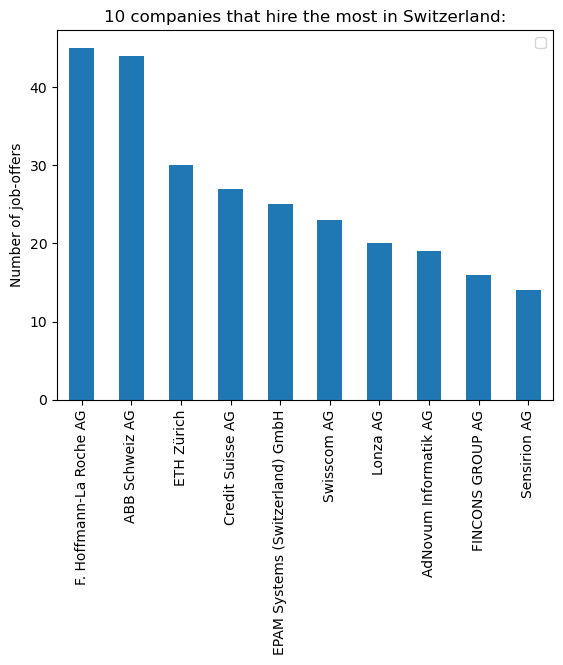

In [12]:
# import matplotlib to visualize data
import matplotlib.pyplot as plt

# create plot
companies_hiring.plot(x="company", y="link", kind="bar")
plt.title("10 companies that hire the most in Switzerland:")
plt.xlabel("")
plt.ylabel("Number of job-offers")
plt.legend([])
plt.show()

## 9. Job offers per location

In [13]:
# create empty dataframe
locations = pd.DataFrame()

# for each job search key count the number of times that a city has different job ad links
for key, df in dataframes.items():
    locations = locations.append(df.groupby("location").link.count().reset_index())

# sort values in descending orders and drop duplicates for subset location
locations = locations.sort_values(by="link", ascending=False)
locations.drop_duplicates(subset=["location"]).head(10)

,location,link
435,Zürich,241
66,Bern,90
429,Zurich,70
52,Basel,50
17,"Basel, Basel-City",40
68,Geneva,28
390,"Turgi, Aargau",28
427,Zollikofen,27
329,Schaffhausen,25
177,Genève,24


## 10. Final considerations

- Being the job postings in different languages, cities such as Zürich and Zurich are shown, therefore additional data wrangling

- Jobs are overlapping and present for more than one keyword, which means in reality the the job ads might be relevant for more than a job search keyword

- When a job hunter is posting on behalf of a company, the company name is not inserted to the job ad. To get only a list of job ads posted directly from companies we should eliminate all rows containing within the company column "Published". The code to do that should look like like this: `discard = ["published"]` and then for any df `df[~df.company.str.contains('|'.join(discard), case=False)]`